## What is Data Science?

The hot takes via [Twitter](https://twitter.com/mcmoots/status/429318287864770560):

- "A data scientist is a statistician who lives in San Francisco." 
- "A data scientist is a business analyst who lives in New York."
- "Data Science is statistics on a Mac."

A more idealistic view:

![Venn Diagram of Data Science](https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/8a34a4f653bdbdc01415a94dc20d4e9b97438965/notebooks/figures/Data_Science_VD.png)

"...think of data science not as a new domain of knowledge to learn, but a new set of skills that you can apply within your current area of expertise." - [Jake VanderPlas](http://vanderplas.com/), Director of Open Software at the University of Washington's eScience Institute.

## So what's the plan?

We're going to combine a touch of stats, a hint of hacking, and a pinch of substantive knowledge about policing to analyze a real data set, collected by researchers at the [Stanford Open Policing Project](https://openpolicing.stanford.edu/).

On a typical day in the United States, police officers make more than **50,000 traffic stops**. Stanford has collected over 200 million records from dozens of state and local police departments across the country in an effort to create a centralized repository detailing interactions between civilians and police. 

We're going to look at a subset of this data: **Maryland in 2013-2014, excluding the City of Baltimore.**

Why just a subset? It keeps the size manageable, plus we avoid the sparse sections of the MD dataset. From Stanford:

> The [Maryland] data is very messy. It comes from three different time periods: 2007, 2009-2012, 2013-2014. They all have different column and slightly different conventions of how things are recorded. We attempted to standardize the fields as much as possible.
Time resolution of the data varies by year. Prior to 2013, data is reported annually. From 2013 onward, data is reported daily. So stop dates prior to 2013 are not precise to the nearest day and are just reported as Jan 1.
Counties were mapped by running the police departments in the Agency field through Google's geocoder, but this does not work for state patrol stops, for which we have no county information.

### 1. Import packages
See all the "as ..." contructs? They're just aliasing the package names.

That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

The aliases used here are conventional in the Python data community.

In [36]:
%matplotlib inline 
# Above line is not necessary in latest version of Notebook, but in older versions
# ensures that plots are displayed inline, not in a separate window

import numpy as np # imports a fast numerical programming library
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.pyplot as plt # sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
import seaborn as sns #sets up styles and gives us more plotting options

In [2]:
# Boilerplate that sets some display options. The defaults are fine too!
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 25)
pd.set_option('display.notebook_repr_html', True)

In [3]:
# This is an f-string. If it doesn't work, you're running a Python version below 3.6. Consider upgrading!
print(f"Numpy Version: {np.__version__}, Pandas Version: {pd.__version__}")

Numpy Version: 1.16.2, Pandas Version: 0.24.1


### 2. Import data

Why `low_memory = False`? Inferring datatypes is very memory intensive and we're only specifying some of the dtypes during import. This suppresses a warning about memory use when we load data without specifying all dtypes.

In [4]:
md = pd.read_csv('md_traffic.csv', low_memory = False, dtype={
    'subject_age': 'float64',
    'subject_race': 'category',
    'subject_sex': 'category',
    'arrest_made': 'bool',
    'outcome': 'category',
    'search_conducted': 'bool',
    'reason_for_arrest': 'category',
    })

##### Aside: Did you know you can measure execution time of small code snippets using the `%timeit` command?

Notice that `timeit` executes the code several times and takes an average of the runs.
Read more about it in the [official documentation](https://docs.python.org/3.7/library/timeit.html).

In [5]:
import random
%timeit array = [random.randint(0, 10) for i in range(100000)]
%timeit values = np.random.randint(0, 10, 100000)

239 ms ± 94.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.91 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


##### Aside #2: Did you know you can access a function's signature & docstring by adding a "?" after a command. E.g. `pd.read_csv?`
It's the equivalent of `print(pd.read_csv.__doc__)` but `?` is a shortcut in the IPython environment.

In [6]:
# 'read_csv' is a Crime Against Nature masquerading as a function, but it gets the job done.
pd.read_csv?

### 3. Basic Data Exploration

In [7]:
# Let's look at the shape of this data.
md.shape

(841853, 23)

QUESTION: Can this CSV file be opened in Excel? What about Apple's Numbers App?

![MS Excel Meme](http://www.quickmeme.com/img/91/913a533644761239481e9ee0f623a8b3284f1e847f5dd96c3d7afb4a68a3097f.jpg)

In [8]:
# Check the index. We see a RangeIndex because we did not specify a column to be an index when reading the csv.
md.index

RangeIndex(start=0, stop=841853, step=1)

In [9]:
# Check the columns.
md.columns

Index(['raw_row_number', 'date', 'time', 'location', 'subject_age', 'subject_race', 'subject_sex',
       'department_name', 'disposition', 'violation', 'arrest_made', 'citation_issued',
       'warning_issued', 'outcome', 'contraband_found', 'contraband_drugs', 'contraband_weapons',
       'search_conducted', 'search_person', 'search_vehicle', 'reason_for_arrest',
       'reason_for_search', 'reason_for_stop'],
      dtype='object')

In [10]:
md.dtypes

raw_row_number           int64
date                    object
time                    object
location                object
subject_age            float64
subject_race          category
subject_sex           category
department_name         object
disposition             object
violation               object
arrest_made               bool
citation_issued         object
warning_issued          object
outcome               category
contraband_found        object
contraband_drugs        object
contraband_weapons      object
search_conducted          bool
search_person           object
search_vehicle          object
reason_for_arrest     category
reason_for_search       object
reason_for_stop         object
dtype: object

In [11]:
# I prefer .info() to .dtypes as the former also tells us how many null points we're dealing with
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841853 entries, 0 to 841852
Data columns (total 23 columns):
raw_row_number        841853 non-null int64
date                  841853 non-null object
time                  841820 non-null object
location              841849 non-null object
subject_age           839810 non-null float64
subject_race          841788 non-null category
subject_sex           841574 non-null category
department_name       841853 non-null object
disposition           27757 non-null object
violation             2759 non-null object
arrest_made           841853 non-null bool
citation_issued       841778 non-null object
warning_issued        841778 non-null object
outcome               745774 non-null category
contraband_found      28455 non-null object
contraband_drugs      28455 non-null object
contraband_weapons    28455 non-null object
search_conducted      841853 non-null bool
search_person         28403 non-null object
search_vehicle        28403 non-null ob

In [12]:
# Peak at the data
md.head(4)

,raw_row_number,date,time,location,subject_age,subject_race,subject_sex,department_name,disposition,violation,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,search_conducted,search_person,search_vehicle,reason_for_arrest,reason_for_search,reason_for_stop
0,2312586,1/2/13,19:12:00,SRT40@W BEL AIR AVE,61.778218,white,male,Aberdeen Police Department,NaN,NaN,False,True,False,citation,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,21-202(h1)
1,2312587,1/2/13,6:15:00,SRT40@JAMES ST,37.974822,white,female,Aberdeen Police Department,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,22-203(b)
2,2312588,1/2/13,21:20:00,1-95 MILE MARKER 80.5,53.112731,white,female,Aberdeen Police Department,NaN,NaN,False,False,True,warning,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,21-301(a)
3,2312589,1/4/13,18:20:00,SRT 40@FRANKLIN ST,49.829976,white,male,Aberdeen Police Department,NaN,NaN,False,True,False,citation,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,16-303(c)


What can we discern just from this look at the data? What about all the NaNs?

We may want to set `raw_row_number` as the index.

In [13]:
#Verify_integrity is set to false by default. Setting to True ensures a unique index.
md.set_index("raw_row_number", verify_integrity=True, inplace=True)

In [14]:
md.head()
# What did the first driver get cited for?

,date,time,location,subject_age,subject_race,subject_sex,department_name,disposition,violation,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,search_conducted,search_person,search_vehicle,reason_for_arrest,reason_for_search,reason_for_stop
raw_row_number,,,,,,,,,,,,,,,,,,,,,,
2312586,1/2/13,19:12:00,SRT40@W BEL AIR AVE,61.778218,white,male,Aberdeen Police Department,NaN,NaN,False,True,False,citation,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,21-202(h1)
2312587,1/2/13,6:15:00,SRT40@JAMES ST,37.974822,white,female,Aberdeen Police Department,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,22-203(b)
2312588,1/2/13,21:20:00,1-95 MILE MARKER 80.5,53.112731,white,female,Aberdeen Police Department,NaN,NaN,False,False,True,warning,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,21-301(a)
2312589,1/4/13,18:20:00,SRT 40@FRANKLIN ST,49.829976,white,male,Aberdeen Police Department,NaN,NaN,False,True,False,citation,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,16-303(c)
2312590,1/4/13,4:20:00,SRT40@MARKET ST,58.361306,white,male,Aberdeen Police Department,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,22-204(f)


We can access individual columns through dot-attribute notation (`md.subject_sex`) or through
getitem dictionary-style notation (`md['subject_sex']`).

QUESTION: Why might the latter be preferable even as the former is somewhat more natural to write?

The return value is a Pandas Series; basically a one-column DataFrame.

In [21]:
# Attribute notation
md.subject_sex.head()

raw_row_number
2312586      male
2312587    female
2312588    female
2312589      male
2312590      male
Name: subject_sex, dtype: category
Categories (2, object): [female, male]

In [22]:
#getitem syntax (uses __.getitem__)
md['outcome'].head()

raw_row_number
2312586    citation
2312587         NaN
2312588     warning
2312589    citation
2312590         NaN
Name: outcome, dtype: category
Categories (3, object): [arrest, citation, warning]

In [23]:
# Access multiple columns with a comma
md[['department_name', 'citation_issued', 'reason_for_stop']].head()

,department_name,citation_issued,reason_for_stop
raw_row_number,,,
2312586,Aberdeen Police Department,True,21-202(h1)
2312587,Aberdeen Police Department,False,22-203(b)
2312588,Aberdeen Police Department,False,21-301(a)
2312589,Aberdeen Police Department,True,16-303(c)
2312590,Aberdeen Police Department,False,22-204(f)


You can index the rows by using the **loc** and **iloc** accessors.

`loc` does *label-based* indexing.

`iloc` performs *integer-based* indexing.

You can use a comma separated list to access multiple fields at the same time.

Both support the standard Python slicing operations `[start:end:step]`

In [24]:
#get the rows for index IDs 3237323 and 2312594
md.loc[[3237323,2312594]]

,date,time,location,subject_age,subject_race,subject_sex,department_name,disposition,violation,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,search_conducted,search_person,search_vehicle,reason_for_arrest,reason_for_search,reason_for_stop
raw_row_number,,,,,,,,,,,,,,,,,,,,,,
3237323,3/31/14,12:01:00,BALTIMORE ST / NORTH POINT BLVD,29.703594,black,male,Baltimore County Police Department,NaN,NaN,False,False,True,warning,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,13-401(h)
2312594,1/5/13,17:53:00,E BEL AIR AVE@POST RD,31.381933,white,female,Aberdeen Police Department,NaN,NaN,False,True,False,citation,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,21-707(a)


In [25]:
#get every tenth row starting from 4100, until 4150.
md.iloc[4100:4150:10]

,date,time,location,subject_age,subject_race,subject_sex,department_name,disposition,violation,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,search_conducted,search_person,search_vehicle,reason_for_arrest,reason_for_search,reason_for_stop
raw_row_number,,,,,,,,,,,,,,,,,,,,,,
2316687,8/21/13,14:44:00,SPA RD @ SILOPANNA,49.085264,white,female,Annapolis Police Department,NaN,NaN,False,True,False,citation,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,21-801.1
2316697,8/21/13,15:25:00,WEST @ S SOUTHWOOD,49.301559,white,male,Annapolis Police Department,NaN,NaN,False,True,False,citation,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,22-412.3(b)
2316707,8/21/13,16:29:00,BYWATER RD @ FOREST DR,24.047070,asian/pacific islander,male,Annapolis Police Department,NaN,NaN,False,True,False,citation,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,13-703(g)
2316717,8/22/13,1:23:00,YAWL RD @ CUTTER COURT,21.541882,black,male,Annapolis Police Department,contra,NaN,True,False,False,arrest,False,False,False,True,True,True,stop,prob,16-303(c)
2316727,8/22/13,12:46:00,FOREST DRIVE AND PAROLE,51.316661,white,female,Annapolis Police Department,NaN,NaN,False,True,False,citation,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,21-502(a2)


In [26]:
# show the first 5 rows and the first 5 columns
md.iloc[:5, :5]

,date,time,location,subject_age,subject_race
raw_row_number,,,,,
2312586,1/2/13,19:12:00,SRT40@W BEL AIR AVE,61.778218,white
2312587,1/2/13,6:15:00,SRT40@JAMES ST,37.974822,white
2312588,1/2/13,21:20:00,1-95 MILE MARKER 80.5,53.112731,white
2312589,1/4/13,18:20:00,SRT 40@FRANKLIN ST,49.829976,white
2312590,1/4/13,4:20:00,SRT40@MARKET ST,58.361306,white


In [27]:
# show the all the rows up to index 2312588 and the columns named 'subject_sex' and 'warning_issued'
md.loc[:2312588, ['subject_sex', 'warning_issued']]

,subject_sex,warning_issued
raw_row_number,,
2312586,male,False
2312587,female,False
2312588,female,True


### 4. Dealing with Data Types and NaN Cleaning 
![Office Space Meme](https://media.makeameme.org/created/i-was-told-592f12.jpg)


We might be worried about the large number of NaNs in the dataset. Another way to quantify our null fields is by summing the result of applying `isnull()` to the dataframe.

In [28]:
# Why does this work? Think about what True and False are equivalent to.
md.isnull().sum()

date                       0
time                      33
location                   4
subject_age             2043
subject_race              65
subject_sex              279
department_name            0
disposition           814096
violation             839094
arrest_made                0
citation_issued           75
warning_issued            75
outcome                96079
contraband_found      813398
contraband_drugs      813398
contraband_weapons    813398
search_conducted           0
search_person         813450
search_vehicle        813450
reason_for_arrest     830190
reason_for_search     813450
reason_for_stop         2076
dtype: int64

But are the null fields really a problem? It depends. If `reason_for_search` is ALWAYS null, we have a problem, but if it's only null when `search_conducted` is False, we're in business.

In [29]:
md.search_conducted == True

raw_row_number
2312586    False
2312587    False
2312588    False
2312589    False
2312590    False
2312591    False
2312592    False
2312593    False
2312594    False
2312595    False
2312596    False
2312597    False
           ...  
3237321    False
3237322    False
3237323    False
3237324    False
3237325    False
3237326    False
3237327    False
3237328    False
3237329    False
3237330    False
3237331    False
3237332    False
Name: search_conducted, Length: 841853, dtype: bool

In [30]:
md[md.search_conducted == True].isnull().sum()

date                      0
time                      0
location                  1
subject_age             103
subject_race              1
subject_sex               2
department_name           0
disposition             702
violation             25795
arrest_made               0
citation_issued           2
warning_issued            2
outcome                 824
contraband_found          4
contraband_drugs          4
contraband_weapons        4
search_conducted          0
search_person            56
search_vehicle           56
reason_for_arrest     17702
reason_for_search        56
reason_for_stop          31
dtype: int64

Looks like `reason_for_search` is null only 56 times when a search has been conducted. An enterprising journalist might want to look at these 56 cases to see if there's anything fishy or if it's just a bookkeeping error (likely!)

If we hadn't done data conversions at import, we could do so now:

Convert column "subject_age" to float64 dtype and "subject_race" to categorical type
`md = md.astype({"subject_age": 'float', "subject_race": 'category'})`

In [31]:
#may want to use string methods to normalize string objects
md.location.str.lower().head()

raw_row_number
2312586      srt40@w bel air ave
2312587           srt40@james st
2312588    1-95 mile marker 80.5
2312589       srt 40@franklin st
2312590          srt40@market st
Name: location, dtype: object

### 5. Exploring the Data More Deeply

Here, the memes stop and we have to be more sober.

Let's look at the kinds of values we find in various columns.

In [32]:
# we can also normalize this
md.subject_sex.value_counts()

male      540049
female    301525
Name: subject_sex, dtype: int64

In [26]:
# can apply functions to columns
md.subject_age.mean()

38.222497698481334

###### QUESTION: Who is the youngest person in this data set? What were they cited for? Does the citation pass the smell test?

In [60]:

# Your Code Here

In [ ]:
# Don't execute until ready to see the answer
%load solution/youngest.py


There are dozens of ways to plot age data. Let's look at two. For more on what KDE means, see [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation).

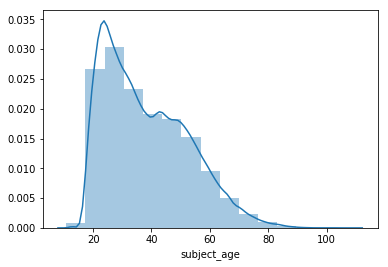

In [64]:
# Seaborn is very pretty!
sns.distplot(md.subject_age[md.subject_age.isnull()==False], kde= True, bins = 15);

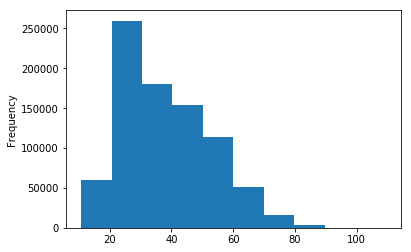

In [62]:
# Pandas (which uses Matplotlib under the hood) is less pretty by default, but very convenient
md.subject_age.plot(kind='hist');

### 6. Exploring Race and Policing

In [145]:
md.subject_race.value_counts()

white                     426220
black                     304582
hispanic                   59986
other/unknown              27736
asian/pacific islander     23264
Name: subject_race, dtype: int64

In [87]:
with pd.option_context('max_rows', 210):
    print(md.department_name.value_counts())

Maryland State Police                                           208287
Baltimore County Police Department                               91602
Montgomery County Police Department                              54627
Maryland Transportation Authority Police                         52474
Anne Arundel County Police Department                            50227
MSP                                                              43277
Prince George's County Police Department                         40937
Howard County Police Department                                  27421
Frederick Police Department                                      19792
MONTGOMERY                                                       18207
Ocean City Police Department                                     13698
MDTA                                                              9965
PGCOPD                                                            9781
Charles County Sheriff's Office                                   9241
Harfor

We have to establish some baseline to determine if the proportion of White, Black, Hispanic, and Asian drivers being pulled over is disproportionate to their share of the population. Since we don't have good data for the whole state, let's compare select counties' traffic stops to their Census populations.

In [103]:
bcpd = md[md.department_name == 'Baltimore County Police Department']
bcpd_by_race = bcpd.subject_race.value_counts(normalize=True)
bcpd_by_race

black                     0.491337
white                     0.402116
hispanic                  0.040090
other/unknown             0.036466
asian/pacific islander    0.029991
Name: subject_race, dtype: float64

We note that Black motorists represent 49% of the people pulled over by the Baltimore County Police Department in 2013 - early 2014. What about Montgomery?

In [157]:
mcpd = md[(md.department_name == 'MONTGOMERY') | (md.department_name == 'Montgomery County Police Department') |(md.department_name == 'Montgomery County Sherrif\'s Office') ]
mcpd_by_race = mcpd.subject_race.value_counts(normalize=True)
mcpd_by_race

white                     0.392733
black                     0.311352
hispanic                  0.175025
asian/pacific islander    0.066357
other/unknown             0.054533
Name: subject_race, dtype: float64

##### EXERCISE: Create a new data frame for PG County 

In [158]:
# your code here


In [ ]:
# Don't execute until ready to see the answer
%load solution/pg.py


See [Census Data](https://www.census.gov/quickfacts/fact/table/princegeorgescountymaryland,baltimorecountymaryland,montgomerycountymaryland,US/PST045218)

In [160]:
baltimore_co_census = pd.Series([.572, .292,.055 ,.064,], index=['white', 'black', 'hispanic', 'asian/pacific islander'])
moco_census = pd.Series([.438, .197, .196, .156,], index=['white', 'black', 'hispanic', 'asian/pacific islander'])

In [161]:
moco_benchmark = pd.concat([mcpd_by_race, moco_census], keys=['police_stops', 'moco_census'], axis = 1)
moco_benchmark

,police_stops,moco_census
asian/pacific islander,0.066357,0.156
black,0.311352,0.197
hispanic,0.175025,0.196
other/unknown,0.054533,NaN
white,0.392733,0.438


Let’s do the same sort of benchmark comparison for search and frisk rates. We can use the stopped population as our baseline, defining search rate to be the proportion of stopped people who were subsequently searched, and frisk rate as proportion of stopped people who were subsequently personally searched.

We'll want to use pandas `GroupBy` functionality to implement the `split-apply-combine` pattern.

The idea here is that we **split** the data by some key or set of keys then **apply** a function to each group and then **combine** the outputs back into a single DataFrame.

In [138]:
# In MoCo, how often are Hispanic drivers searched after being pulled over? Asian drivers?
mcpd.groupby('subject_race').search_conducted.value_counts(normalize=True)

subject_race            search_conducted
asian/pacific islander  False               0.977235
                        True                0.022765
black                   False               0.934236
                        True                0.065764
hispanic                False               0.938800
                        True                0.061200
other/unknown           False               0.977084
                        True                0.022916
white                   False               0.956221
                        True                0.043779
Name: search_conducted, dtype: float64

In [141]:
# How often are drivers frisked during a stop?
mcpd[mcpd.search_conducted == True].groupby('subject_race').search_person.value_counts(normalize=True)

subject_race            search_person
asian/pacific islander  True             0.872727
                        False            0.127273
black                   True             0.847753
                        False            0.152247
hispanic                True             0.852564
                        False            0.147436
other/unknown           True             0.725275
                        False            0.274725
white                   True             0.794728
                        False            0.205272
Name: search_person, dtype: float64

In [162]:
# What about statewide?
md.groupby('subject_race').search_conducted.value_counts(normalize=True)

subject_race            search_conducted
asian/pacific islander  False               0.980872
                        True                0.019128
black                   False               0.958445
                        True                0.041555
hispanic                False               0.957090
                        True                0.042910
other/unknown           False               0.980350
                        True                0.019650
white                   False               0.971289
                        True                0.028711
Name: search_conducted, dtype: float64

In [156]:
md[md.search_conducted == True].groupby('subject_race').search_person.value_counts(normalize=True)

subject_race            search_person
asian/pacific islander  True             0.866516
                        False            0.133484
black                   True             0.832239
                        False            0.167761
hispanic                True             0.843701
                        False            0.156299
other/unknown           True             0.805915
                        False            0.194085
white                   True             0.861109
                        False            0.138891
Name: search_person, dtype: float64

![https://imgs.xkcd.com/comics/correlation.png](https://imgs.xkcd.com/comics/correlation.png)

**"Correlation doesn't imply causation, but it does waggle its eyebrows suggestively and gesture furtively while mouthing 'look over there'."** - [XKCD 552](https://www.explainxkcd.com/wiki/index.php/552:_Correlation)

To get closer to causality, we can use the "outcome test" in which a lower search  success rate for one group relative to another is seen as evidence of bias against that group, as it suggests a lower evidentiary bar was applied when making search decisions.

In [165]:
# pay close attention to the figure for Hispanics
md[md.search_conducted == True].groupby('subject_race').contraband_found.value_counts(normalize=True)

subject_race            contraband_found
asian/pacific islander  False               0.995506
                        True                0.004494
black                   False               0.986250
                        True                0.013750
hispanic                False               0.991841
                        True                0.008159
other/unknown           False               0.994495
                        True                0.005505
white                   False               0.987251
                        True                0.012749
Name: contraband_found, dtype: float64

In [169]:
md[md.search_conducted == True].groupby('subject_race').outcome.value_counts(normalize=True)

subject_race            outcome 
asian/pacific islander  arrest      0.559908
                        citation    0.255760
                        warning     0.184332
black                   arrest      0.428513
                        citation    0.361505
                        warning     0.209982
hispanic                arrest      0.590873
                        citation    0.296032
                        warning     0.113095
other/unknown           arrest      0.417769
                        warning     0.293006
                        citation    0.289225
white                   arrest      0.541410
                        warning     0.238352
                        citation    0.220238
Name: outcome, dtype: float64

In [170]:
mcpd[mcpd.search_conducted == True].groupby('subject_race').outcome.value_counts(normalize=True)

subject_race            outcome 
asian/pacific islander  arrest      0.458716
                        citation    0.339450
                        warning     0.201835
black                   arrest      0.492852
                        citation    0.286590
                        warning     0.220558
hispanic                arrest      0.619296
                        citation    0.247718
                        warning     0.132986
other/unknown           arrest      0.444444
                        warning     0.288889
                        citation    0.266667
white                   arrest      0.530612
                        citation    0.252245
                        warning     0.217143
Name: outcome, dtype: float64

### 7. Closing Remarks

## Attribution And Further Exploration

- Jake VanderPlas: [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/): Free, CC License, available as a series of Jupyter Notebooks. Chapter 3 has strong coverage of Pandas.
- [dataMontgomery](https://data.montgomerycountymd.gov/): Montgomery County, MD offers excellent datasets on various public services, including law enforcement. For example, its 1.4 million row/35 column dataset on traffic stops has data on vehicle make/model, city of origin of the driver, and exact geolocation of the stop.
- [The Stanford Open Policing Project](https://openpolicing.stanford.edu/): See the whole dataset, plus a tutorial on how to work with it (unfortunately in R)
- [Kaggle DataSets](https://www.kaggle.com/datasets): Collection of datasets, many amendable to machine learning techniques